# Glassdoor Search Result Analysis
## `Job title: Data Scientist`
## `Location: Ontario`

# Raw Dataset:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import re

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.width', 200)

raw_df = pd.read_csv('file:///C:/Users/11/Desktop/python%20projects/Glassfloor/Glassdoor%20scrapping/Selenium/output%20files/dataset1/scrapped jobs - 06-21-2021 18h33m31s.csv')
df = raw_df
df

,Company,Job Title,Location,Employer Estimated Salary,Easy Apply,Special Label,Job Age,Overall Rating,Compensation & Benefit,Culture & Value,Career Opportunitie,Work/Life Balanc,Job Type,Job Function,Industry,Size,Founded,Type,Sector,Revenue,Recommend to a friend,Approve of CEO,Total Ratings,Job Description,Scraping Start Time: 06-21-2021 18h33m31s,"Starting Link: https://www.glassdoor.ca/Job/ontario-data-scientist-jobs-SRCH_IL.0,7_IS4080_KO8,22.htm"
0,AIR MILES,Data Scientist Lead,Midtown Toronto,NaN,False,Actively Hiring,3d,3.2,3.1,3.0,2.8,3.3,Full-time,Data Scientist,Advertising & Marketing,501 to 1000 Employees,1992.0,Company - Private,Business Service,$1 to $2 billion (USD),44%,44%,5 Ratings,It's fun to work in a company where people tru...,NaN,NaN
1,Pink Triangle Press,Research & Analytical Director - Data Scientist,Midtown Toronto,CA$84k - CA$106k (Glassdoor Est.),True,Hiring Surge,4d,3.5,3.4,3.7,2.3,3.9,Full-time,Data Scientist,Publishing,51 to 200 Employees,NaN,Company - Private,Media,$1 to $5 million (USD),55%,100%,1 Ratings,Pink Triangle Press (PTP) is looking for a Res...,NaN,NaN
2,Leonardo Canada - Electronics (TTI - Tactical ...,Radar E/W Scientists,Ottawa,NaN,True,NaN,6d,NaN,NaN,NaN,NaN,NaN,Full-time,Research Scientist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"RadarE/W Scientists, Ottawa Canada\r\nRemote w...",NaN,NaN
3,Sun Life Financial,Data Analyst,Waterloo,CA$56k - CA$95k (Glassdoor Est.),False,Top Company,3d,4.0,3.8,4.1,3.8,3.9,Full-time,Data Analyst,Insurance Operator,10000+ Employees,1865.0,Company - Public,Insurance,$10+ billion (USD),84%,96%,370 Ratings,"You are as unique as your background, experien...",NaN,NaN
4,Russell Hendrix Foodservice Equipment,Data Analyst,Midtown Toronto,NaN,True,HOT,16d,3.0,2.9,2.9,2.8,2.9,Full-time,Data Analyst,NaN,501 to 1000 Employees,NaN,Company - Public,NaN,Unknown / Non-Applicable,51%,80%,5 Ratings,"With over 70 years of experience, Russell Hend...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,CyberCoders,Sr. Machine Learning Engineer - Facial Recogni...,Midtown Toronto,NaN,True,New,24h,4.1,3.7,4.0,4.1,3.8,Full-time,Machine Learning Engineer,Staffing & Outsourcing,201 to 500 Employees,1999.0,Subsidiary or Business Segment,Business Service,$100 to $500 million (USD),72%,87%,42 Ratings,Sr. Machine Learning Engineer - Facial Recogni...,NaN,NaN
896,Lixar I.T,Senior Data Engineer,Midtown Toronto,CA$120k - CA$140k (Glassdoor Est.),True,NaN,22d,NaN,NaN,NaN,NaN,NaN,Full-time,Data Engineer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lixar fuelled by BDO is looking for a Senior D...,NaN,NaN
897,Spin Master Ltd,Sr. Data Engineer,Midtown Toronto,CA$95k - CA$120k (Glassdoor Est.),False,NaN,6d,3.1,3.1,3.1,2.9,2.6,Full-time,Data Engineer,Consumer Products Manufacturing,1001 to 5000 Employees,1994.0,Company - Public,Manufacturing,$2 to $5 billion (USD),51%,64%,142 Ratings,Are you a kid at heart looking to build a care...,NaN,NaN
898,Gore Mutual Insurance Company,Lead Data Engineer,Cambridge,NaN,True,NaN,19d,3.0,3.3,3.6,2.9,3.5,Full-time,Data Engineer,Insurance Operator,201 to 500 Employees,1839.0,Company - Private,Insurance,$100 to $500 million (USD),62%,68%,9 Ratings,The Data Engineering practice at Gore Mutual I...,NaN,NaN


# Data Cleaning:

In [3]:
# Drop last three columns
# Drop job desc column because duplicate job postings can have slightly different job desc due to how glassdoor work
df = df.iloc[:,:-3]

# Drop duplicates
df.drop_duplicates(inplace=True)

# Find rows with relevant job functions (count of 10 or more)
relevance_group = df.groupby('Job Function').count()
relevance_group = relevance_group[relevance_group['Company'] >= 10]
relevant_job_funcs = relevance_group.index.tolist()

# Remove rows with irrelevant job funcitons
df = df[df['Job Function'].isin(relevant_job_funcs)]

# Ratings distribution:

Text(0, 0.5, 'Number of Postings')

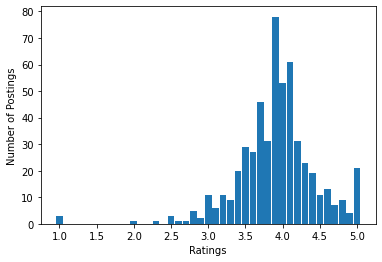

In [4]:
ratings_group = df.groupby('Overall Rating').count()['Company']
ratings = ratings_group.index
company_count = ratings_group
plt.bar(ratings, company_count, width=.09)
plt.xlabel('Ratings')
plt.ylabel('Number of Postings')

# What are the effects of Easy Apply?

In [5]:
# Add 'Job Age in Hours' column

def convert_to_hour(time):
    if time[-1] == 'd':
        return 24*float(time[:-1])
    elif time[-1] == '+':
        return 24*float(time[:-2])
    return float(time[:-1])

# .apply is not the most efficient but we don't have a lot of data
df['Job Age in Hours'] = df['Job Age'].apply(convert_to_hour)
temp_df = raw_df
temp_df = temp_df.iloc[:,:-3]
temp_df['Job Age in Hours'] = temp_df['Job Age'].apply(convert_to_hour)

In [6]:
print(temp_df.groupby('Easy Apply').count()['Company'])
temp_df.groupby('Easy Apply').mean()

Easy Apply
False    547
True     353
Name: Company, dtype: int64


,Overall Rating,Compensation & Benefit,Culture & Value,Career Opportunitie,Work/Life Balanc,Founded,Job Age in Hours
Easy Apply,,,,,,,
False,3.916571,3.677586,3.853065,3.674138,3.697701,1957.342048,326.127971
True,3.891176,3.629766,3.866890,3.658528,3.855853,1991.440000,288.135977


## Summary:
### • ~39% of all job postings uses the Easy Apply feature
### • Newer companies use the feature more
### • When Easy Apply is enabled:
### `12% decreased time to fill the position on average`
### `4.1% lower Work/Life Balance rating on average`

# What are the effects of Company Age?

In [7]:
# Only looking at unique companies
# Remove rows with duplicate company
company_df = df.drop_duplicates(['Company'], keep='first').drop(columns=['Job Title', 'Job Type', 'Employer Estimated Salary', 'Special Label', 'Job Age', 'Easy Apply', 'Job Age in Hours'])

Text(0.5, 1.0, 'Company Age vs Overall Rating')

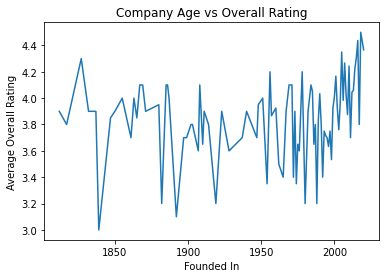

In [8]:
company_df = company_df[~company_df['Founded'].isna()]

founded_group = company_df.groupby('Founded').mean()
founded = founded_group.index

plt.plot(founded, founded_group['Overall Rating'])
plt.xlabel('Founded In')
plt.ylabel('Average Overall Rating')
plt.title('Company Age vs Overall Rating')


Text(0.5, 1.0, 'Company Age vs Career Opportunity')

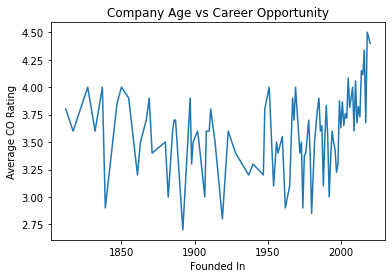

In [9]:
plt.plot(founded, founded_group['Career Opportunitie'])
plt.xlabel('Founded In')
plt.ylabel('Average CO Rating')
plt.title('Company Age vs Career Opportunity')

## Summary:
### • Companies founded after year ~2000 have higher overall ratings and career opportunities ratings

# What are the effects of location?

## Create Career Oppotunity dataframe:

In [10]:
# Drop all rows where 'Career Opportunitie' is NaN
co_df = df[~df['Career Opportunitie'].isna()]

# Find rows with relevant locations (count of 5 or more)
relevance_group = co_df.groupby('Location').count()
relevance_group = relevance_group[relevance_group['Company'] >= 5]
relevant_locs = relevance_group.index.tolist()

# Remove rows with irrelevant locations
co_df = co_df[df['Location'].isin(relevant_locs)]

<ipython-input-10-cb3e40b874d0>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  co_df = co_df[df['Location'].isin(relevant_locs)]


Text(0.5, 1.0, 'Location vs Career Opportunity')

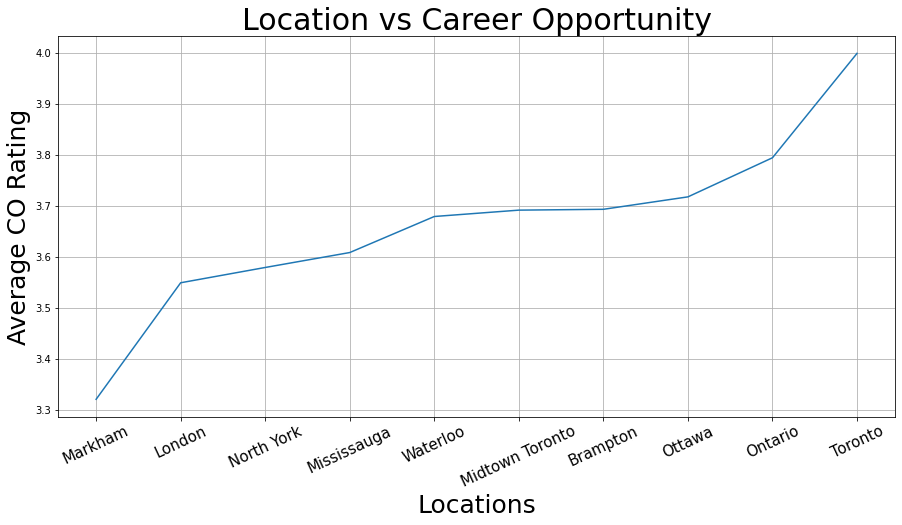

In [11]:
loc_group = co_df.groupby('Location').mean().sort_values('Career Opportunitie')
# Drop rows where 'Career Opportunities is NaN'
loc_group = loc_group[~loc_group['Career Opportunitie'].isna()]

locations = loc_group.index

plt.figure(figsize=(15,7))
plt.grid()

plt.plot(locations, loc_group['Career Opportunitie'])
plt.xticks(locations, size=15, rotation=25)
plt.xlabel('Locations', size=25)
plt.ylabel('Average CO Rating',size=25)
plt.title('Location vs Career Opportunity', size=30)

## Create Salary dataframe:

In [12]:
# Remove rows with NaN Salary
salary_df = df[~df['Employer Estimated Salary'].isna()]

# Find rows with relevant locations (count of 5 or more)
relevance_group = salary_df.groupby('Location').count()
relevance_group = relevance_group[relevance_group['Company'] >= 5]
relevant_locs = relevance_group.index.tolist()

# Remove rows with irrelevant locations
salary_df = salary_df[df['Location'].isin(relevant_locs)]

salary_pattern = re.compile('\d+')
def to_annual_salary(salary_string):

	salary_range_list = salary_pattern.findall(salary_string)

	est_salary = sum([float(i) for i in salary_range_list])/len(salary_range_list)

	if 'per hour' in salary_string.lower():
		return est_salary*2080
	return est_salary*1000

salary_df['Estimated Salary'] = salary_df['Employer Estimated Salary'].apply(to_annual_salary)

<ipython-input-12-3105ce97c862>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  salary_df = salary_df[df['Location'].isin(relevant_locs)]


Text(0.5, 1.0, 'Location vs Salary')

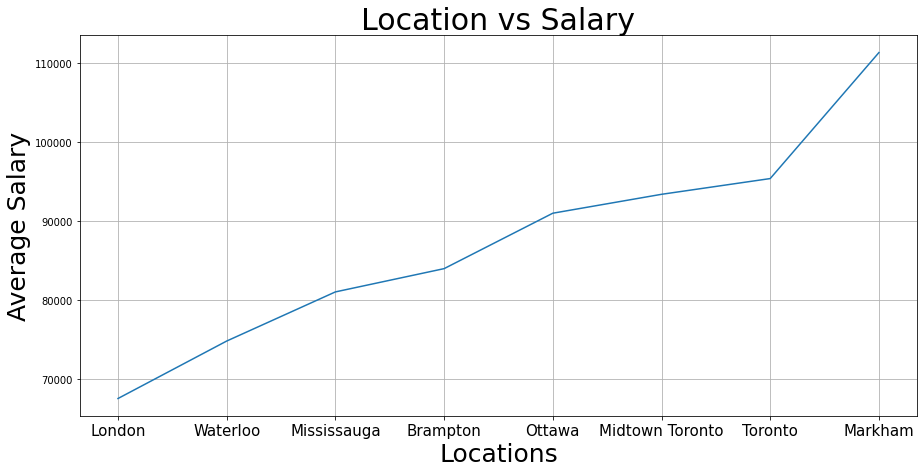

In [13]:
loc_group = salary_df.groupby('Location').mean().sort_values('Estimated Salary')
locations = loc_group.index

plt.figure(figsize=(15,7))
plt.grid()

plt.plot(locations, loc_group['Estimated Salary'])
plt.xticks(locations, size=15)
plt.xlabel('Locations', size=25)
plt.ylabel('Average Salary',size=25)
plt.title('Location vs Salary', size=30)

## Create career opportunity and salary dataframe:

In [14]:
# Remove rows with NaN salary values or NaN CO values
co_salary_df = salary_df[~salary_df['Career Opportunitie'].isna()]

<ipython-input-15-d131c08cc42e>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(locations, size=15)


Text(0.5, 1.0, 'Salary vs Career Opportunity (by Location)')

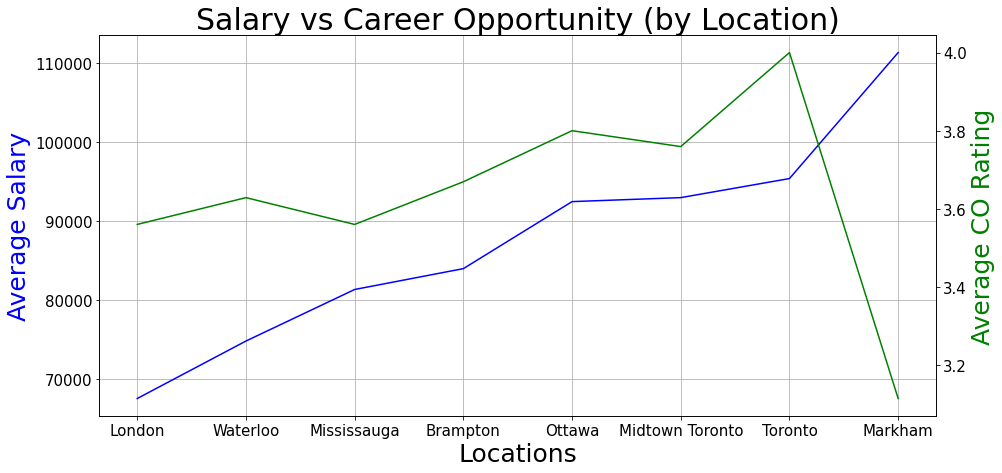

In [15]:
loc_group = co_salary_df.groupby('Location').mean().sort_values('Estimated Salary')
locations = loc_group.index

fig, ax1 = plt.subplots(figsize=(15,7))
ax1.grid()

ax2 = ax1.twinx()
ax1.plot(locations, loc_group['Estimated Salary'], color='b')
ax2.plot(locations, loc_group['Career Opportunitie'], color='g')

ax1.set_xlabel('Locations', size=25)
ax1.set_ylabel('Average Salary', color='b', size=25)
ax2.set_ylabel('Average CO Rating', color='g', size=25)

# Ticks
ax1.set_xticklabels(locations, size=15)
ax1.tick_params(axis='y', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)

plt.title('Salary vs Career Opportunity (by Location)', size=30)


# What Job Functions are most in demand? What are their Salaries?

<ipython-input-16-42368dfb8eea>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(job_func, size=15)


Text(0.5, 1.0, 'Career Opportunity vs Salary (by Job Function)')

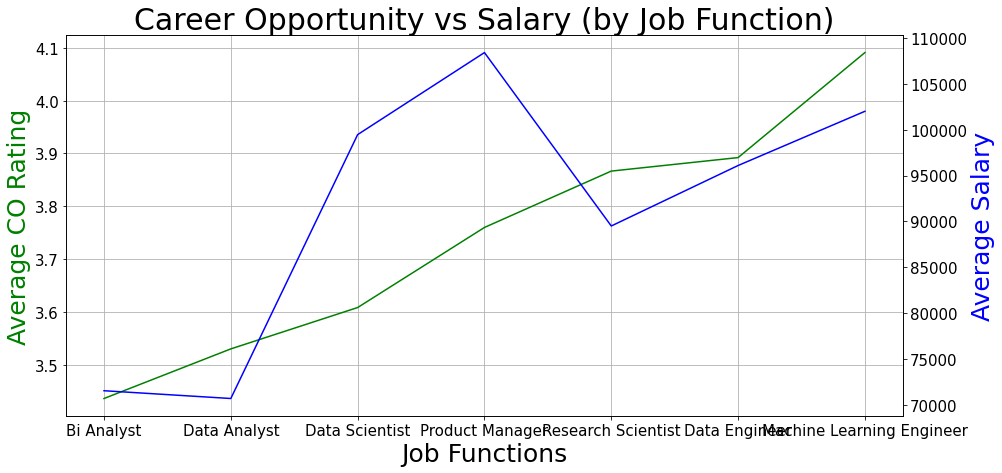

In [16]:
job_func_group = co_salary_df.groupby('Job Function').mean().sort_values('Career Opportunitie')
job_func = job_func_group.index

fig, ax1 = plt.subplots(figsize=(15,7))
ax1.grid()

ax2 = ax1.twinx()
ax1.plot(job_func, job_func_group['Career Opportunitie'], color='g')
ax2.plot(job_func, job_func_group['Estimated Salary'], color='b')

ax1.set_xlabel('Job Functions', size=25)
ax1.set_ylabel('Average CO Rating', color='g', size=25)
ax2.set_ylabel('Average Salary', color='b', size=25)

# Ticks
ax1.set_xticklabels(job_func, size=15)
ax1.tick_params(axis='y', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)

plt.title('Career Opportunity vs Salary (by Job Function)', size=30)



# Salary vs Career Oppotunity by Company

<ipython-input-17-e775cdf6ec9f>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(companies, rotation='vertical', size=15)


Text(0.5, 1.0, 'Salary vs Career Oppounity (by Company)')

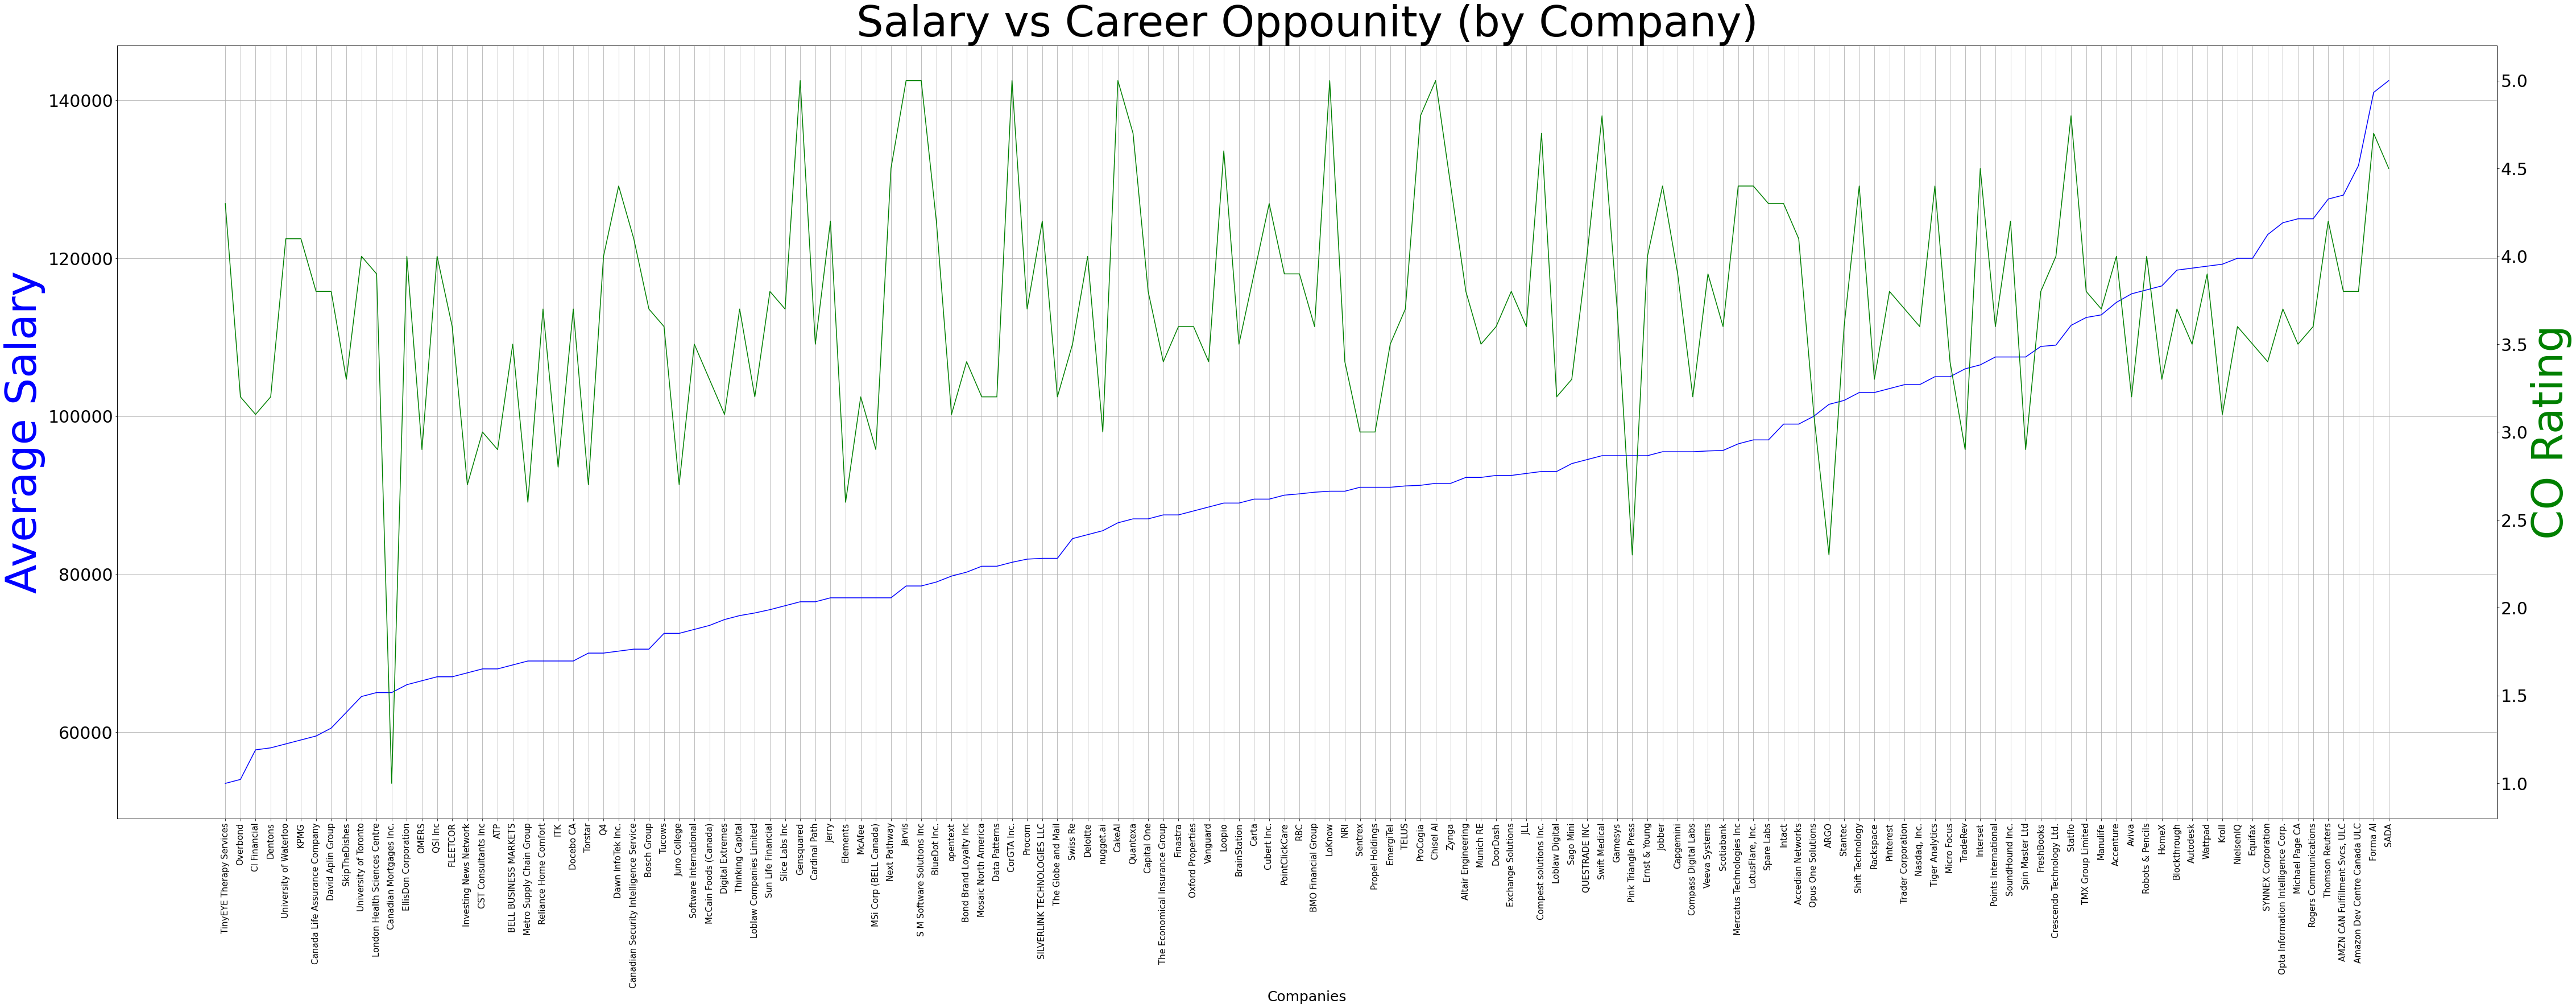

In [17]:
company_group = co_salary_df.groupby('Company').mean().sort_values('Estimated Salary')
companies = company_group.index

fig, ax1 = plt.subplots(figsize=(75,25))
ax1.grid()

ax2 = ax1.twinx()
ax1.plot(companies, company_group['Estimated Salary'], color='b')
# The CO rating of a company is the same as the average CO rating of the company because ratings are unique to a company
ax2.plot(companies, company_group['Career Opportunitie'], color='g')

ax1.set_xlabel('Companies', size=25)
ax1.set_ylabel('Average Salary', color='b', size=75)
ax2.set_ylabel('CO Rating', color='g', size=75)

# Ticks
ax1.set_xticklabels(companies, rotation='vertical', size=15)
ax1.tick_params(axis='y', labelsize=30)
ax2.tick_params(axis='y', labelsize=30)

plt.title('Salary vs Career Oppounity (by Company)', size=75)


# Let's analyze the job description of the job with the highest salary:

In [18]:
# Find the highest salary job
highest_salary_job = salary_df[salary_df['Estimated Salary'] == max(salary_df['Estimated Salary'])]
highest_salary_job

,Company,Job Title,Location,Employer Estimated Salary,Easy Apply,Special Label,Job Age,Overall Rating,Compensation & Benefit,Culture & Value,Career Opportunitie,Work/Life Balanc,Job Type,Job Function,Industry,Size,Founded,Type,Sector,Revenue,Recommend to a friend,Approve of CEO,Total Ratings,Job Age in Hours,Estimated Salary
473,Amazon Dev Centre Canada ULC,"Machine Learning Engineer, Ad Tech Search Expe...",Midtown Toronto,CA$138k - CA$169k (Glassdoor Est.),False,NaN,9d,3.8,3.9,3.6,3.8,3.2,Full-time,Machine Learning Engineer,Internet,10000+ Employees,1994.0,Company - Public,Information Technology,$10+ billion (USD),72%,80%,24044 Ratings,216.0,153500.0


In [19]:
with open('C:/Users/11/Desktop/python projects/Glassfloor/Glassdoor scrapping/Selenium/output files/dataset1/highest_salary_job_desc.txt', 'r') as file:
    job_desc = file.read().replace('\n', ' ')
job_desc

"Master's degree in Electrical Engineering, Computer Sciences, or Mathematics with specialization in speech recognition, natural language processing, image processing, or machine learning. 3+ years relevant industry experience Experience with programming languages such as C/C++, Python, Java or Perl. Amazon is looking for a passionate, talented, and inventive Scientist with a strong machine learning background to help build industry-leading Speech and Language technology. Our mission is to push the envelope in Automatic Speech Recognition (ASR), Natural Language Understanding (NLU), and Audio Signal Processing, in order to provide the best-possible experience for our customers.  As a Scientist, you will work with talented peers to develop novel algorithms and modeling techniques to advance the state of the art in spoken language understanding. Your work will directly impact our customers in the form of products and services that make use of speech and language technology. You will leve

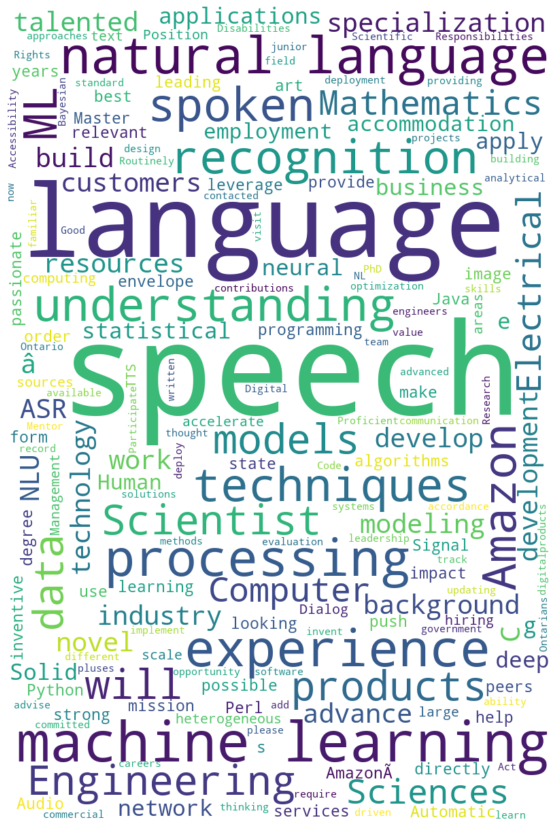

In [20]:
from wordcloud import WordCloud, STOPWORDS

stop_words = ["https", "co", "RT"] + list(STOPWORDS)

wc = WordCloud( ## declare a Wordcloud
    background_color = 'white',
    stopwords = stop_words, ## words that we want to ignore
    height = 1200,
    width = 800
)

wc.generate(job_desc)

plt.figure(figsize=(25,15))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# wc.to_file('wordcloud_output.png') ## outputs wordcloud as .png file

In [21]:
# loc_group.to_csv('location average.csv')
# job_func_group.to_csv('job function average.csv')